# Prediction of Customer Star Ratings from Text Reviews on Seedly 
### CE7454 Project
#### Group 07: Dwivedi Vijay Prakash, Goli Haveesh, Ahn Chung Soo

## 1. Motivation and idea

Online user ratings are important to improve service of a company and help users in their decision making before they buy a product. Customer review systems of today ask for two inputs: the text comments and the star rating. We see two potential problems here – i) some customers give ratings which may not be in coherence with their comments; and ii) the star rating as a user input is redundant because they can be influenced by the star ratings given by other customers which are publicly visible on the website and might not reflect the genuine opinion of the user. Deep learning based language models have achieved wide success in text classification. 

The aim of this project is to predict the user rating (1 to 5) directly from customer reviews (text) using Transformer based neural network architecture. Thus, the customers need not give any star rating for the service or product they have purchased, just their experience in a few words or sentences shall be automated into star rating by the machine learning model.



In [5]:
import os
import multiprocessing as mp
import numpy as np
import json
import pandas as pd
import re
import torch.nn as nn
from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer)
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import collections

## 2. Data Acquisition

We have a novel dataset which is real and targeted to customers in Singapore. The dataset is scraped from [Seedly](https://seedly.sg/), a community platform where customers can post their reviews as per product. Since the data scraped from Seedly is small in size (5,478 text reviews), we also use another larger dataset [Yelp Review Dataset](https://www.kaggle.com/athoul01/predicting-yelp-ratings-from-review-text/data) (5,261,668 text reviews) which is public.

We first perform experiments with our models using the seedly dataset in the pipeline and then augment the training with the Yelp data.

### 2.1 Data Scraping
We scrap the customer reviews from seedly using wget command. As a sample, we have downloaded one product review and saved it to a .csv file. The tabular form of the sample can be seen below in the output.

In [17]:
def wget_seedly_download(f):
    cmdstring = 'wget "https://api.seedly.sg/api/v4/product/items/{}/reviews?i={}&per=501"'.format(f, f)
    t
    os.system(cmdstring)
    print("Downloaded!!")
    return 0

lst = np.array(range(251)) + 1
pool = mp.Pool(mp.cpu_count())

# Downloading 1 sample product reviews
results = pool.starmap_async(wget_seedly_download, [[234]]).get()
# To download all samples run below instead
# results = pool.starmap_async(wget_magic, [[j] for j in lst]).get()

pool.close()

###### DOWNLOADED #####

# Making dataframe from json data
lst = os.listdir(os.path.join(os.getcwd()))

df = []

for f in lst:
    if 'reviews' in f:
            with open('' + f, 'r') as j:
                obj = json.load(j)
                dict_lst = obj.get('data')
                if dict_lst != None:
                    for dic in dict_lst:
                        df.append({'ratings': dic['rating'], 'text': ' '.join(dic['text'].split('\n'))})

tbl = pd.DataFrame(df)
tbl.to_csv('seedly.csv', index=False)
tbl

Downloaded!!


ratings                                               text
0        5  Amex customer service is good, with platinum s...
1        5  Whenever I have chance to use Amex (bad points...

### 2.2 Data Pre-processing
Some of the words obtained from the data scrapper were found to include speacial characters, any such words were removed as these representations are not defined in the context of meaningful review. Further, all the single characters were removed and if any multiple spaces between words were found, they were substituted with single spaces. Also, all the text was converted to lowercase as our models are trained for case sensitive data. We have selected 5 documents as a sample and performed the pre-processing to demonstrate the result. The output below shows the pre-processed sample text review.

In [6]:
seedly_df = pd.read_csv('data_seedly/seedly.csv')

X = seedly_df['text'].tolist()
y = seedly_df['ratings'].tolist()

from collections import Counter
print("The class distribution is: ", Counter(y))

documents = []
for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()

    documents.append(document)

The class distribution is:  Counter({5: 3448, 4: 1217, 3: 364, 1: 319, 2: 130})


In [29]:
documents[:5]

['no frills telco but do give existing customers something to look forward to too looking to switch to giga if it doesn improve ',
 'application process the application process was really smooth just need my phone and my bank card ready applied online and waited for my new sim to arrive it actually arrived next day despite applying on sunday afternoon connection in mrt travelled the red line daily played mobile legend while on train didn experience much of connection drop as compared to my previous telco signal in underground is pretty strong and fast but definitely not as good as above the ground price as ve ported in from other telco get an additional 2gb month free for only 28 month with no contract somemore many other telco are starting to offer sim only plans but the reason to stay with circle is because they offer 500mb month for every 6 months staying with them meaning that in ur 2 years contract with other telco ll be getting additional 2gb month free for staying with circle ',

## 3. Data Visualization

### 3.1 Seedly Dataset Visualization

Total number of reviews: 5,478  
Total number of words: 333,771  
Number of unique word tokens: 1,622  

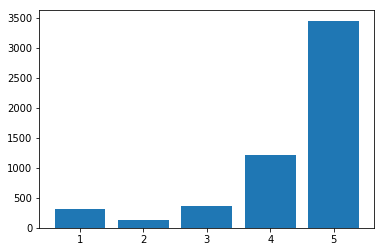

Figure 1: Distribution of review ratings in seedly


In [7]:
hist_dict = Counter(seedly_df['ratings'].tolist())
# plt.bar(hist_dict.keys(), hist_dict.values(), 5, color='g')

x = np.arange(5)
od = collections.OrderedDict(sorted(hist_dict.items()))
freq = np.array(list(od.values()))

def millions(x, pos):
    'The two args are the value and tick position'
    return '%d' % (x)


formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, freq)
plt.xticks(x, ('1', '2', '3', '4', '5'))
plt.show()
print("Figure 1: Distribution of review ratings in seedly")

### Word cloud for Reviews on the "Seedly dataset". 


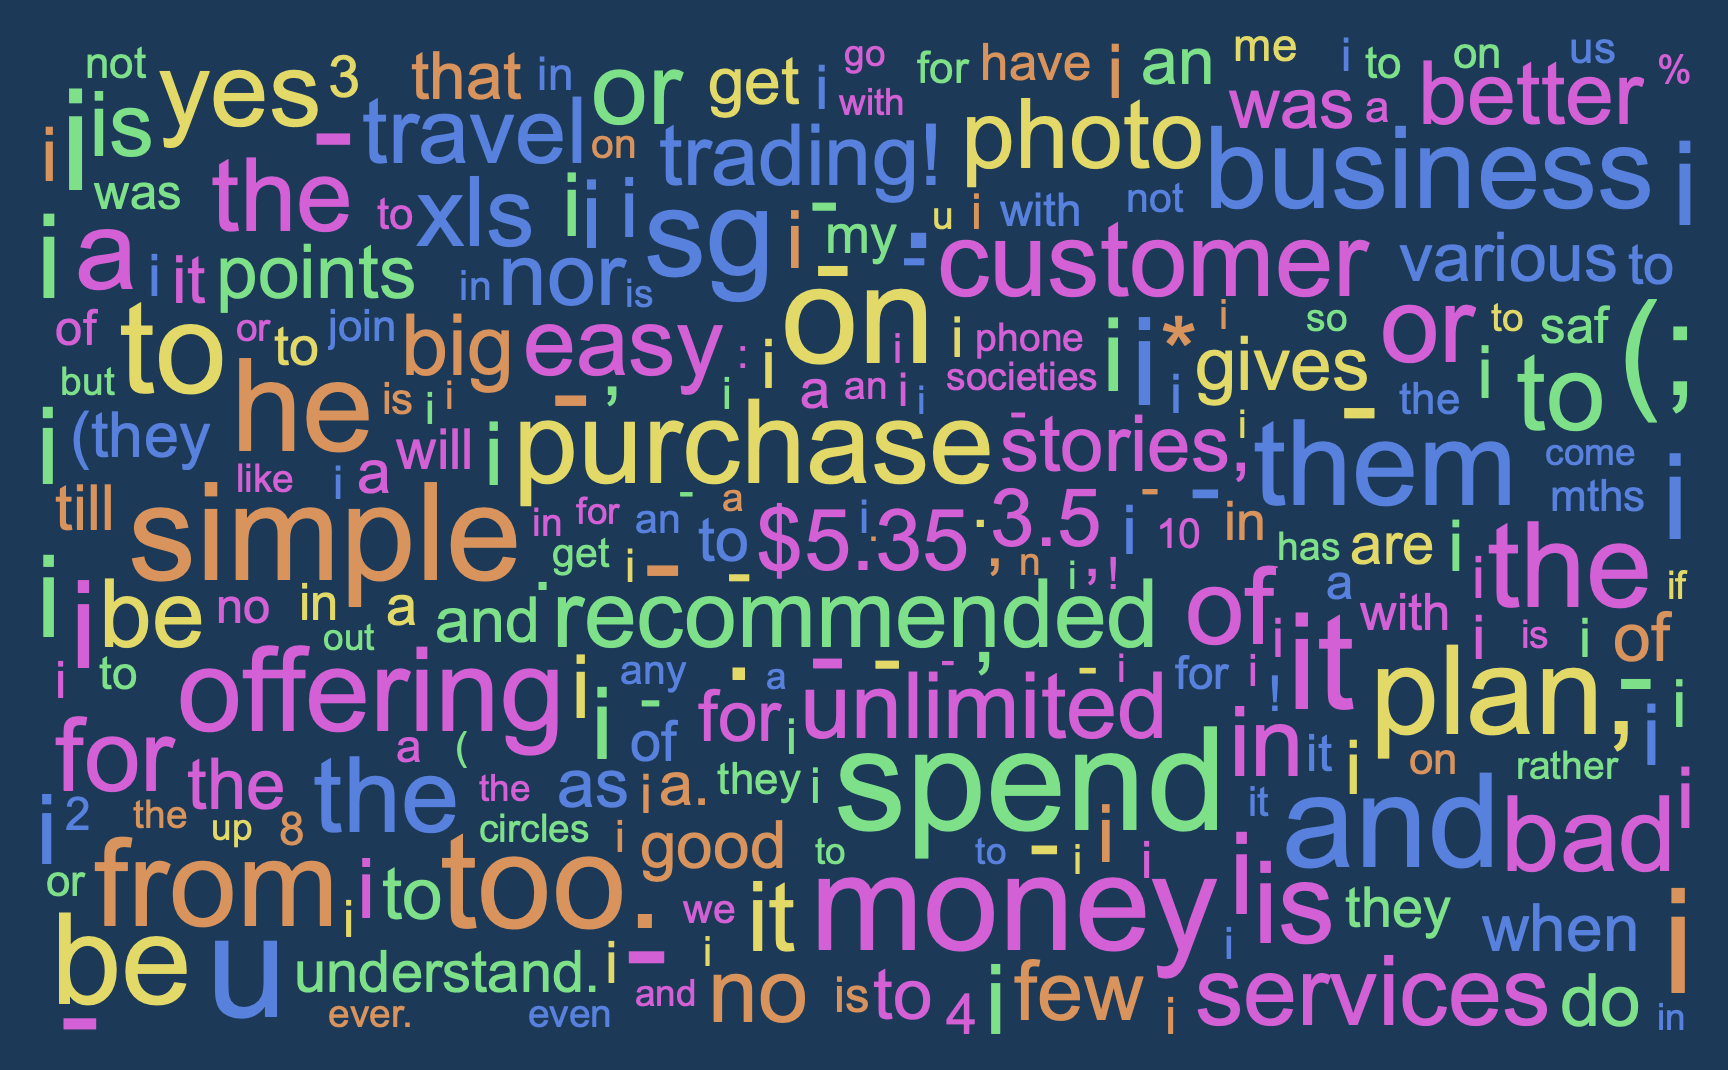

Figure 2: Word cloud of seedly dataset

### Revelations from Seedly data Analysis  
- Since the class imbalance of the seedly data is clear from the above chart, we do not follow the normal random splitting process. Instead, we perform stratified sampling using sklearns' library function which preserves the distribution of class labels in the train, val and test splits.   
- The word cloud diagram gives us the sense of the words that are frequently used by the users in their reviews. Words like 'simple', 'recommended', 'easy', 'big', etc inform us the reason why there are more 5 star ratings. 

### 3.2 Yelp Dataset Visualization

We have analysed the yelp dataset to make some data inferences. 
<br>**Note**: We have done the data visualization in 'R' language as 'R studio' provides more statistical tools for analysis. You can find the data visualization report with the 'R' code [here](https://entuedu-my.sharepoint.com/:b:/g/personal/haveesh001_e_ntu_edu_sg/ETKvwuTuxRpFkTpXbX_dApYB7rQqRAaGnOAZzbzFkTscow?e=jtwIhw).
We are presenting the important results of the analysis here.
The Yelp Dataset is publicly available as part of the Yelp Dataset Challenge. It includes information about local businesses in 10 cities across 4 countries.
**We have analysed reviews limited to restaurants only** as there are over 80,000 businesses where there are close to 3million reviews of customers. Since, the scope of the analysis cannot be so large, we have done a detailed analyses of the Restaurants mainly, Restaurants in Pittsburgh.
By exploring this data we are trying to answer a couple of interesting questions like- 1. What is the distribution of Average Ratings like over-all? 2. Is there a correlation between the Price-Range that a restaurant falls under and it’s Average Rating? 3. Where are the maximum number of 5 star rated restaurants located (within the scope of our data-set)? 4. What are the top categories that most of the 5 star rated restaurants fall under? 5. Which city is the veggie-friendly’s paradise?

The key attributes of the data are as follows:
- 5.2M reviews
- 566K business attributes, e.g., hours, parking availability, ambience etc.,
- Social network of 687K users for a total of 4.2M social edges
- Aggregated check-ins over time for each of the 86K businesses
- 200,000 pictures from the included businesses.


The distribution of ratings is considerably skewed, there are a lot more 4 and 5 star ratings than 1,2 and 3. we could say that people seem to review things they like. In general, people seem to be more likely to write a review for a positive experience than a negative one.

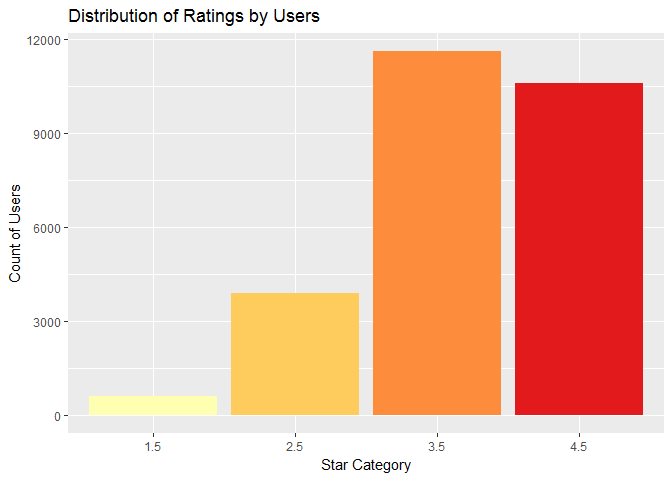

## 4. Models
Our main objective is to build a classifier which predicts the rating on the seedly reviews with a high performance accuracy.

We follow a 2-step process.
- We build baseline classifier (BoW), LSTM and BERT models using only seedly dataset
- We then train the LSTM and BERT models using Yelp dataset first, then train again on seedly dataset and finally test on the seedly test set.  
- We show below, for every model, the test accuracy results and the heatmap for the confusion matrix.

### 4.1 Train from Seedly only

Seedly Data Split.  
- Train/Val/Test: 8:1:1 (4,382, 547, 547 samples)

### 4.1.1 Bag of Words
- We start with a Bag of Words based model first to have an initial baseline performance which is obtained without considering the sequential information of the text reviews. We train on sklearn Logistic Regression classifier, Linear SVC Classifier and an MLP Classifier.  

- For all these 3 classifiers, we use a TF-IDF feature vector of length 1500.  
- The MLP network has 2 hidden layers with 256 hidden neurons each.  

The class distribution is:  Counter({4: 2758, 3: 974, 2: 291, 0: 255, 1: 104})

[R] The accuracy score for LogisticRegression is: 0.6514598540145985


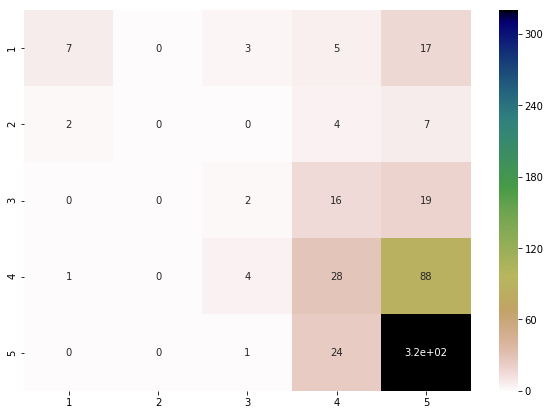


[R] The accuracy score for LinearSVC is: 0.6459854014598541


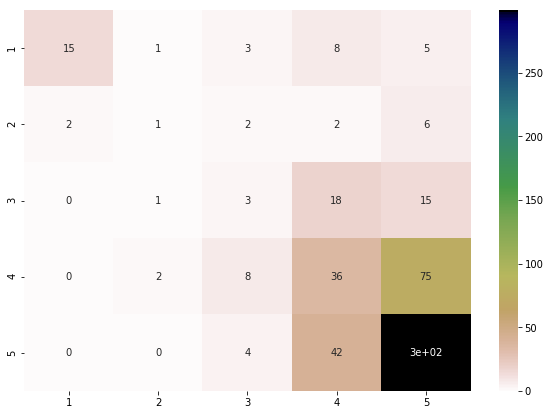

MLP MODEL DETAILS:

MLP(
  (fc1): Linear(in_features=1500, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)
Total parameters: 385541

Test Accuracy of MLP model: 0.6624


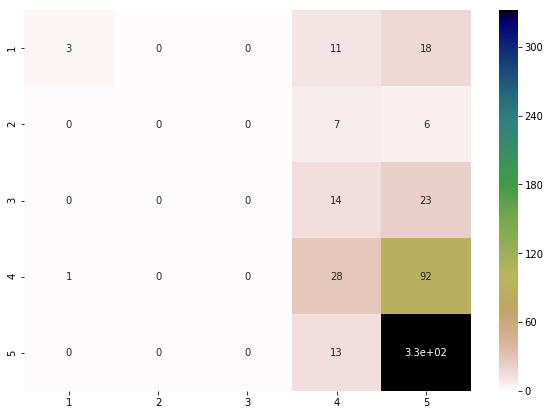

In [29]:
# sklearn classifiers
def run_sklearn_classifier(classifier, X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print("\n[R] The accuracy score for {} is: {}".format(str(classifier).split('(')[0], accuracy_score(y_test, y_pred)))

    df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = [i for i in "12345"],
                      columns = [i for i in "12345"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap='gist_earth_r')

# mlp classifier
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out
    
%run ./bag_of_words.ipynb

### 4.1.2 LSTM
As the above models (BOW based) do not take into consideration the sequence of data, we now move to LSTM (RNN based).

We use 3 layers of stacked LSTMs in our model. The embedding dimension and hidden number of neurons was 256 each. We take maximum sequence length of 128.

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/chungsoo002/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.

Loading model from outputs_seedly_logged_LSTM_report_lowdim2/pytorch_model.bin




Test Accuracy of LSTM model trained on seedly dataset: 0.6332

Total parameters: 9003269


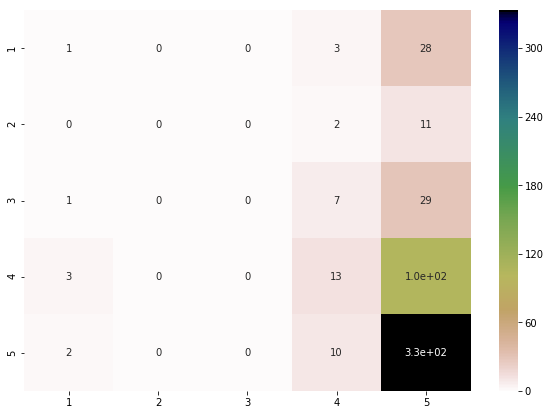

In [30]:
%run ./run_model_seedly_LSTM_report.ipynb

#### Learning curves for LSTM training on seedly data
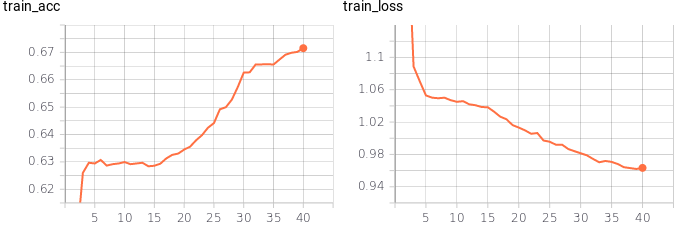
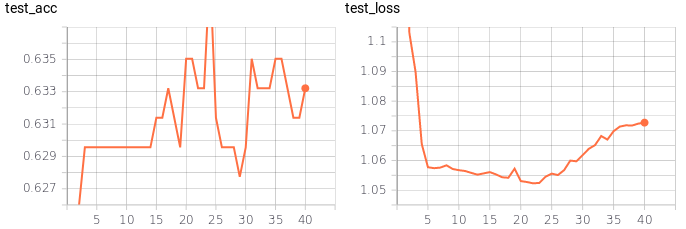

### 4.1.3 BERT

BERT is a new way of pre-training language representations on large text corpus which can then be used for several NLP tasks. In our case, we use pre-trained BERT model `BERT-Base, cased` for classifying the text reviews into one of the 5 classes.

The model consists of:
- 12-layers
- 768-hidden features  
- 12-heads    
- 108M parameters. 

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/chungsoo002/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.



Test Accuracy of BERT model trained on seedly dataset: 0.6715

Total parameters: 108314117


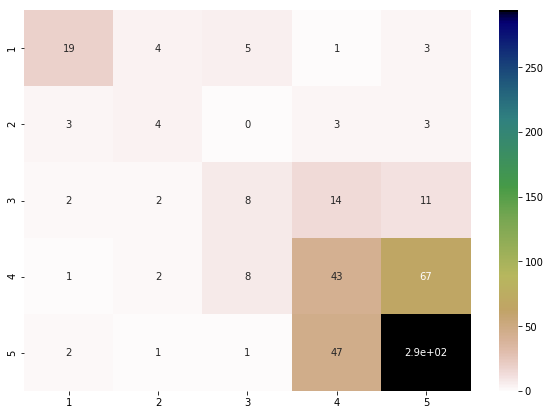

In [31]:
%run ./run_model_seedly_BERT_report.ipynb

#### Learning curves for BERT training on seedly data
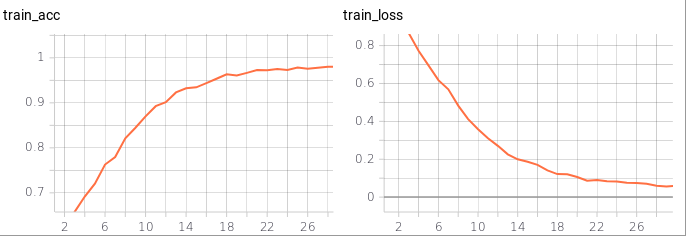
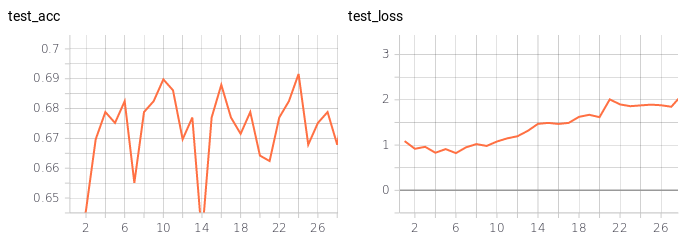

## 4.2 Train from Yelp and Seedly
- Original Yelp Data: 5.26 million reviews  
- Yelp Data We Used: 20% = 1.05 million reviews
- Train/Val/Test Split: 8:1:1 (852K, 100K, 100K samples)  

We now use the Yelp dataset for a 2-step training. We first train on the Yelp data, save the model checkpoints, then use seedly train split to fine-tune the model parameters and finally test on the seedly test split.

### 4.2.1 LSTM
The model configuration is:
- 5 layers  
- 768 hidden features  
- 128 seq length  
- 45 M parameters


INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/chungsoo002/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.

Loading model from outputs_yelp_logged_LSTM_report/pytorch_model.bin




Test Accuracy of LSTM model trained on yelp dataset tested on yelp: 0.6435

Total parameters: 45896453


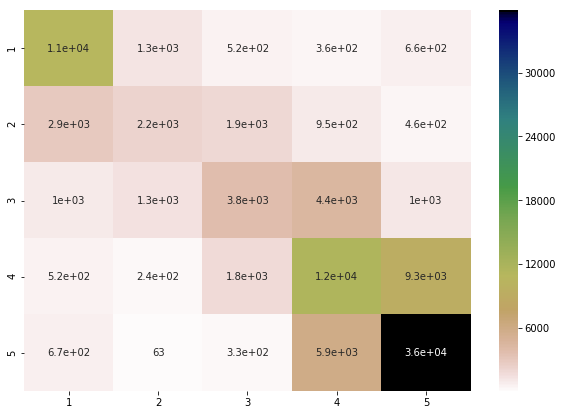

Loading model from outputs_seedly_logged_LSTM_report_transfer/pytorch_model.bin




Test Accuracy of LSTM model trained on yelp dataset tested on seedly: 0.6442

Total parameters: 45896453


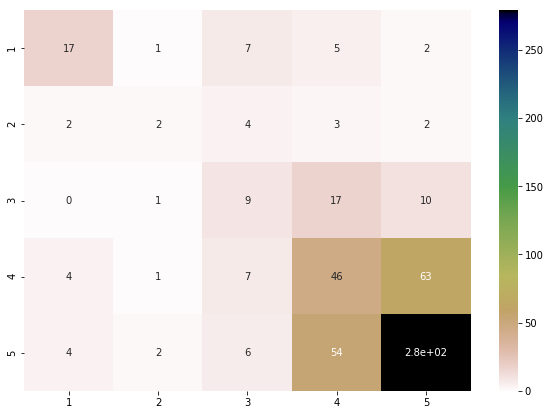

In [3]:
%run ./run_model_yelp_LSTM_report.ipynb

#### Learning curves for LSTM training on YELP data
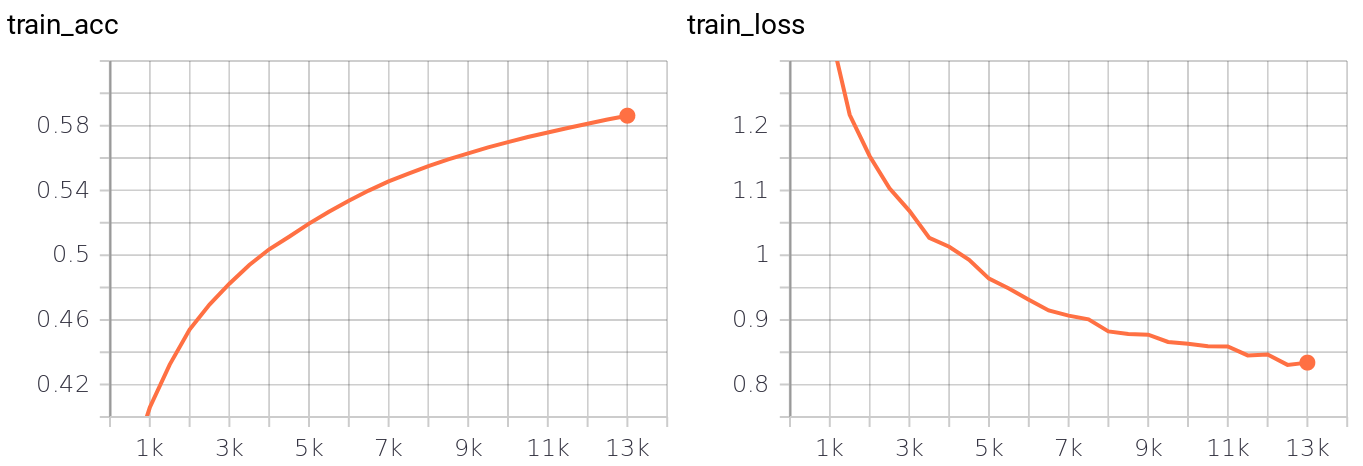
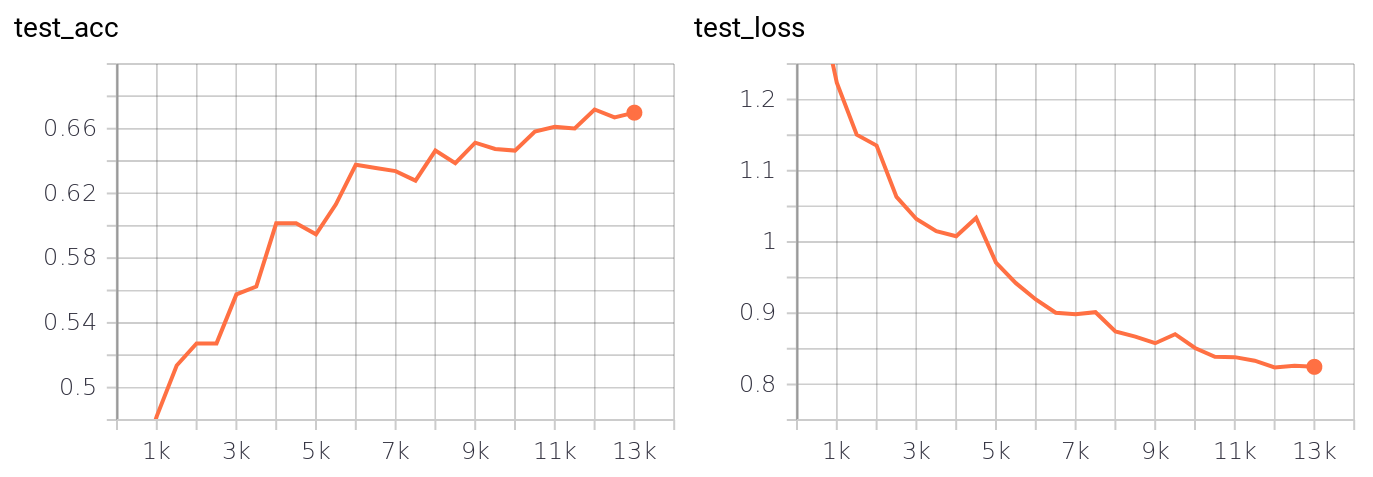

### 4.2.2 BERT
The model consists of:
- 12-layers  
- 768-hidden features  
- 12-heads  
- 108M parameters  


INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/chungsoo002/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.



Test Accuracy of BERT model trained on yelp dataset tested on yelp: 0.7188

Total parameters: 108314117


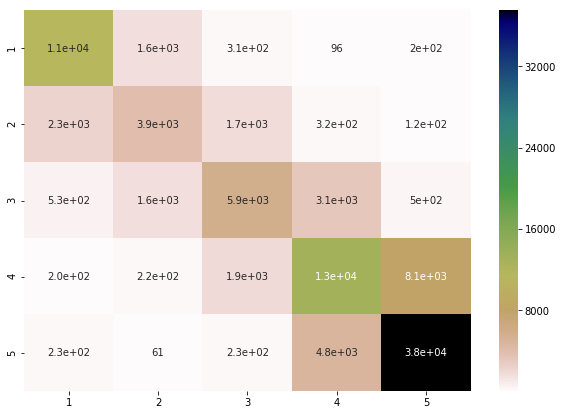

INFO:pytorch_transformers.modeling_utils:loading configuration file outputs_seedly_logged_BERT_report_transfer/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file outputs_seedly_logged_BERT_report_transfer/pytorch_model.bin




Test Accuracy of BERT model trained on yelp dataset tested on seedly: 0.7117

Total parameters: 108314117


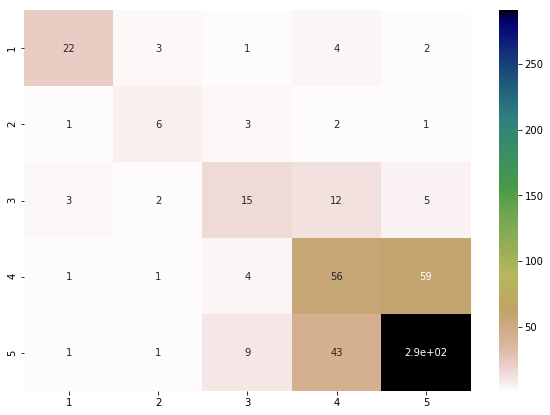

In [2]:
%run ./run_model_yelp_BERT_report.ipynb

#### Learning curves for BERT training on Yelp data
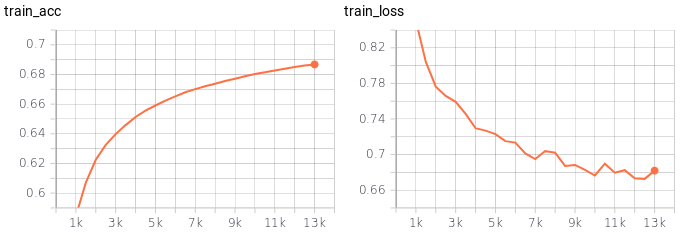
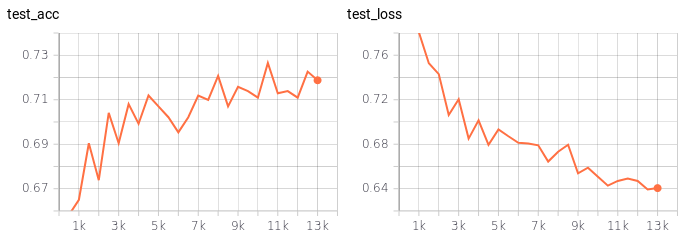

## 5. Discussion

In this section, we discuss the results and note important inferences from our experiments.

### Table 1: Performance Measures on the Seedly Test Data; The last column has the results after the 2-step training process
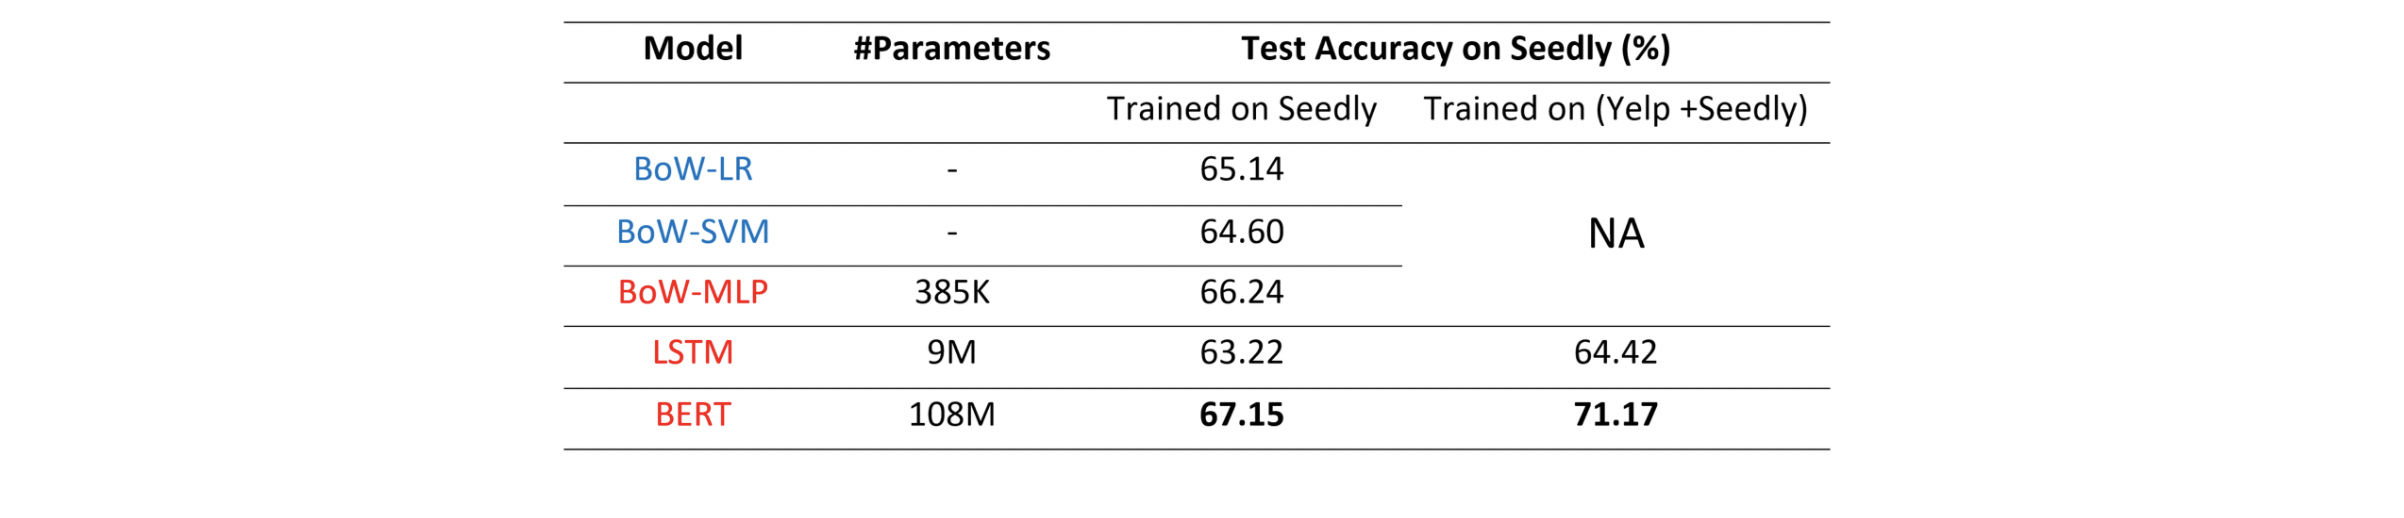

We report highest test accuracies of 63.22% (LSTM) and 67.15% (BERT) when the model is trained on the seedly train data while the test accuracies are 64.42% (LSTM) and 71.17% (BERT) when the models are pre-trained on Yelp data and fine-tuned on the seedly train split. The reason, we attribute, to this improvement is the pre-training of the models on a significantly larger data sample than the seedly. Since there are quite less number of text samples in seedly, the deep learning models do not perform to their capacities.

When we do model-wise comparison of the performance measures of LSTM and BERT, we observe ~4% and ~7% increase of test accuracy in seedly training and yelp+seedly training respectively. This further confirms the potential of transformer-based models, of which, BERT is an instance.

### Table 2: Test Accuracy on the Yelp Test Dataset 
The performance measures shown in Table 2 are on the Yelp test split. As discussed above, BERT scores are still high by a significant margin when compared to LSTM for the Yelp dataset as well. 
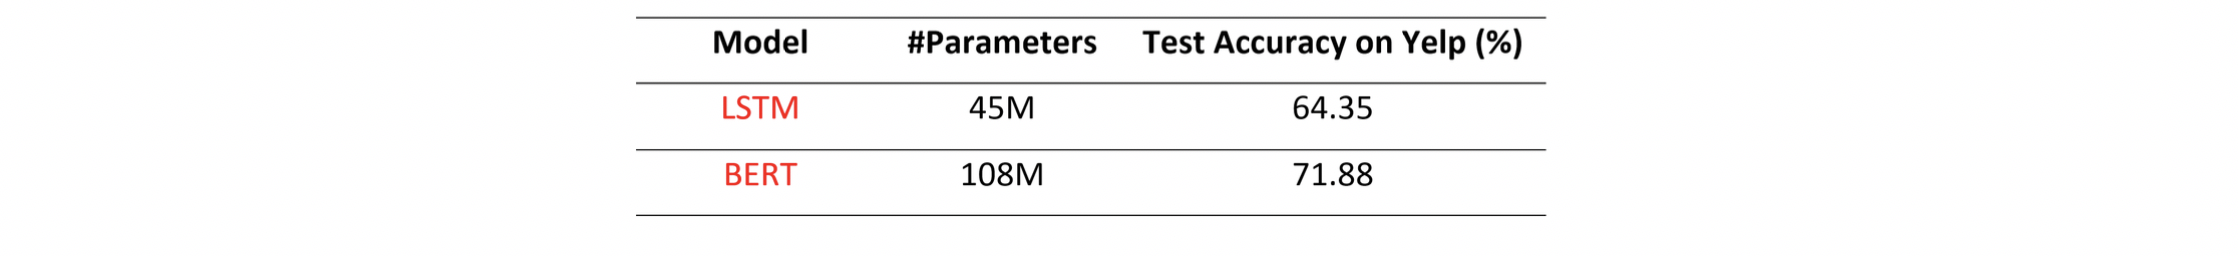

### Heatmaps of the confusion matrices of all the seven classifier models

We show below the confusion matrices of the Bag of Words based models, LSTM and BERT. We observe gradual improvements in the labels' prediction where there were lesser samples in the training set. For instance, the class labels 1 and 2 have 319 and 130 samples respectively out of the total 5000+ seedly data. The first four models (Logistic Regression, SVM, MLP and LSTM-seedly) fail to properly classify these 2 labels. However, we see these classes are better classified by BERT and has the maximum correct prediction score (22 on class 1) when it is trained on yelp + seedly data.

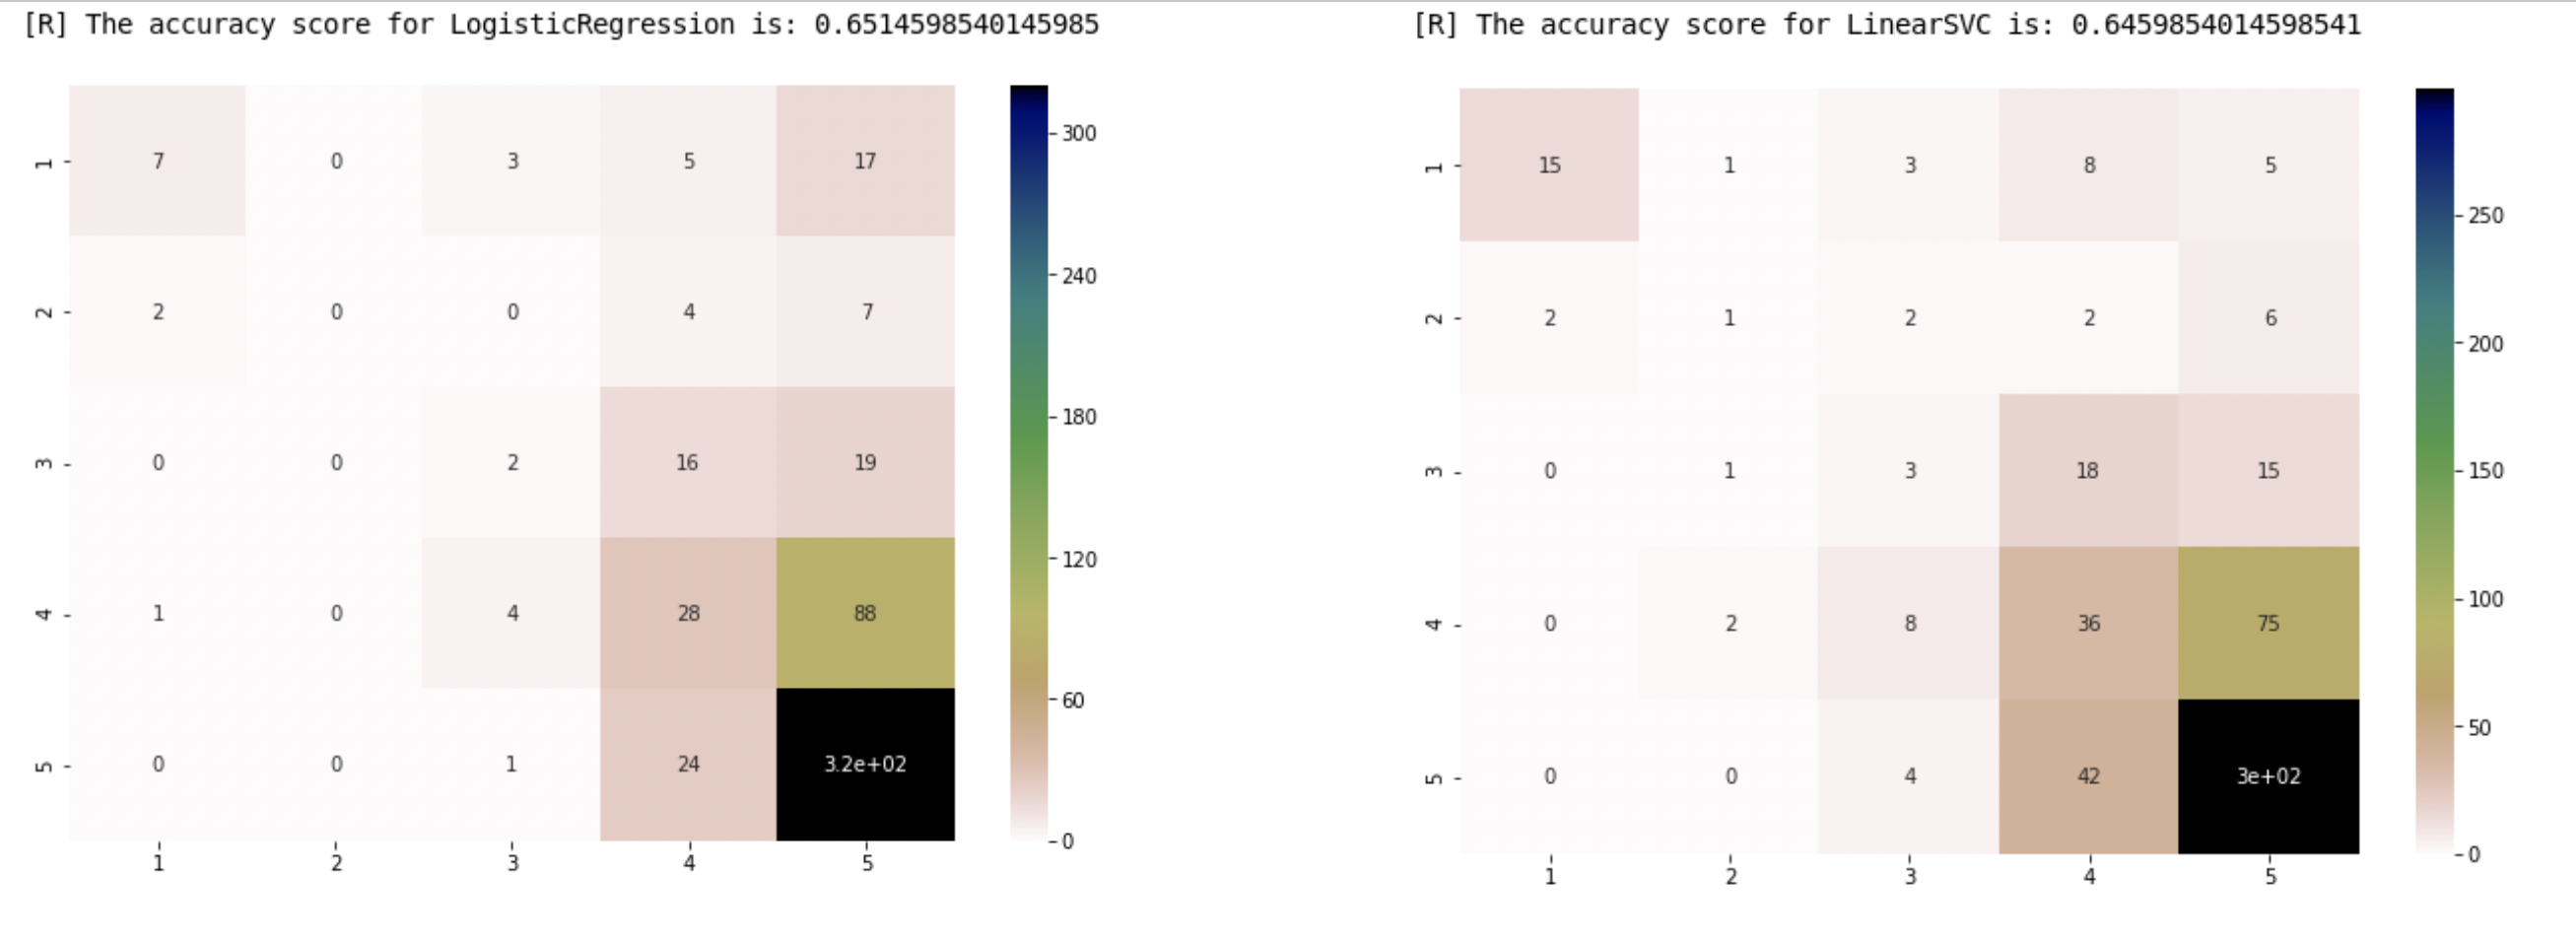

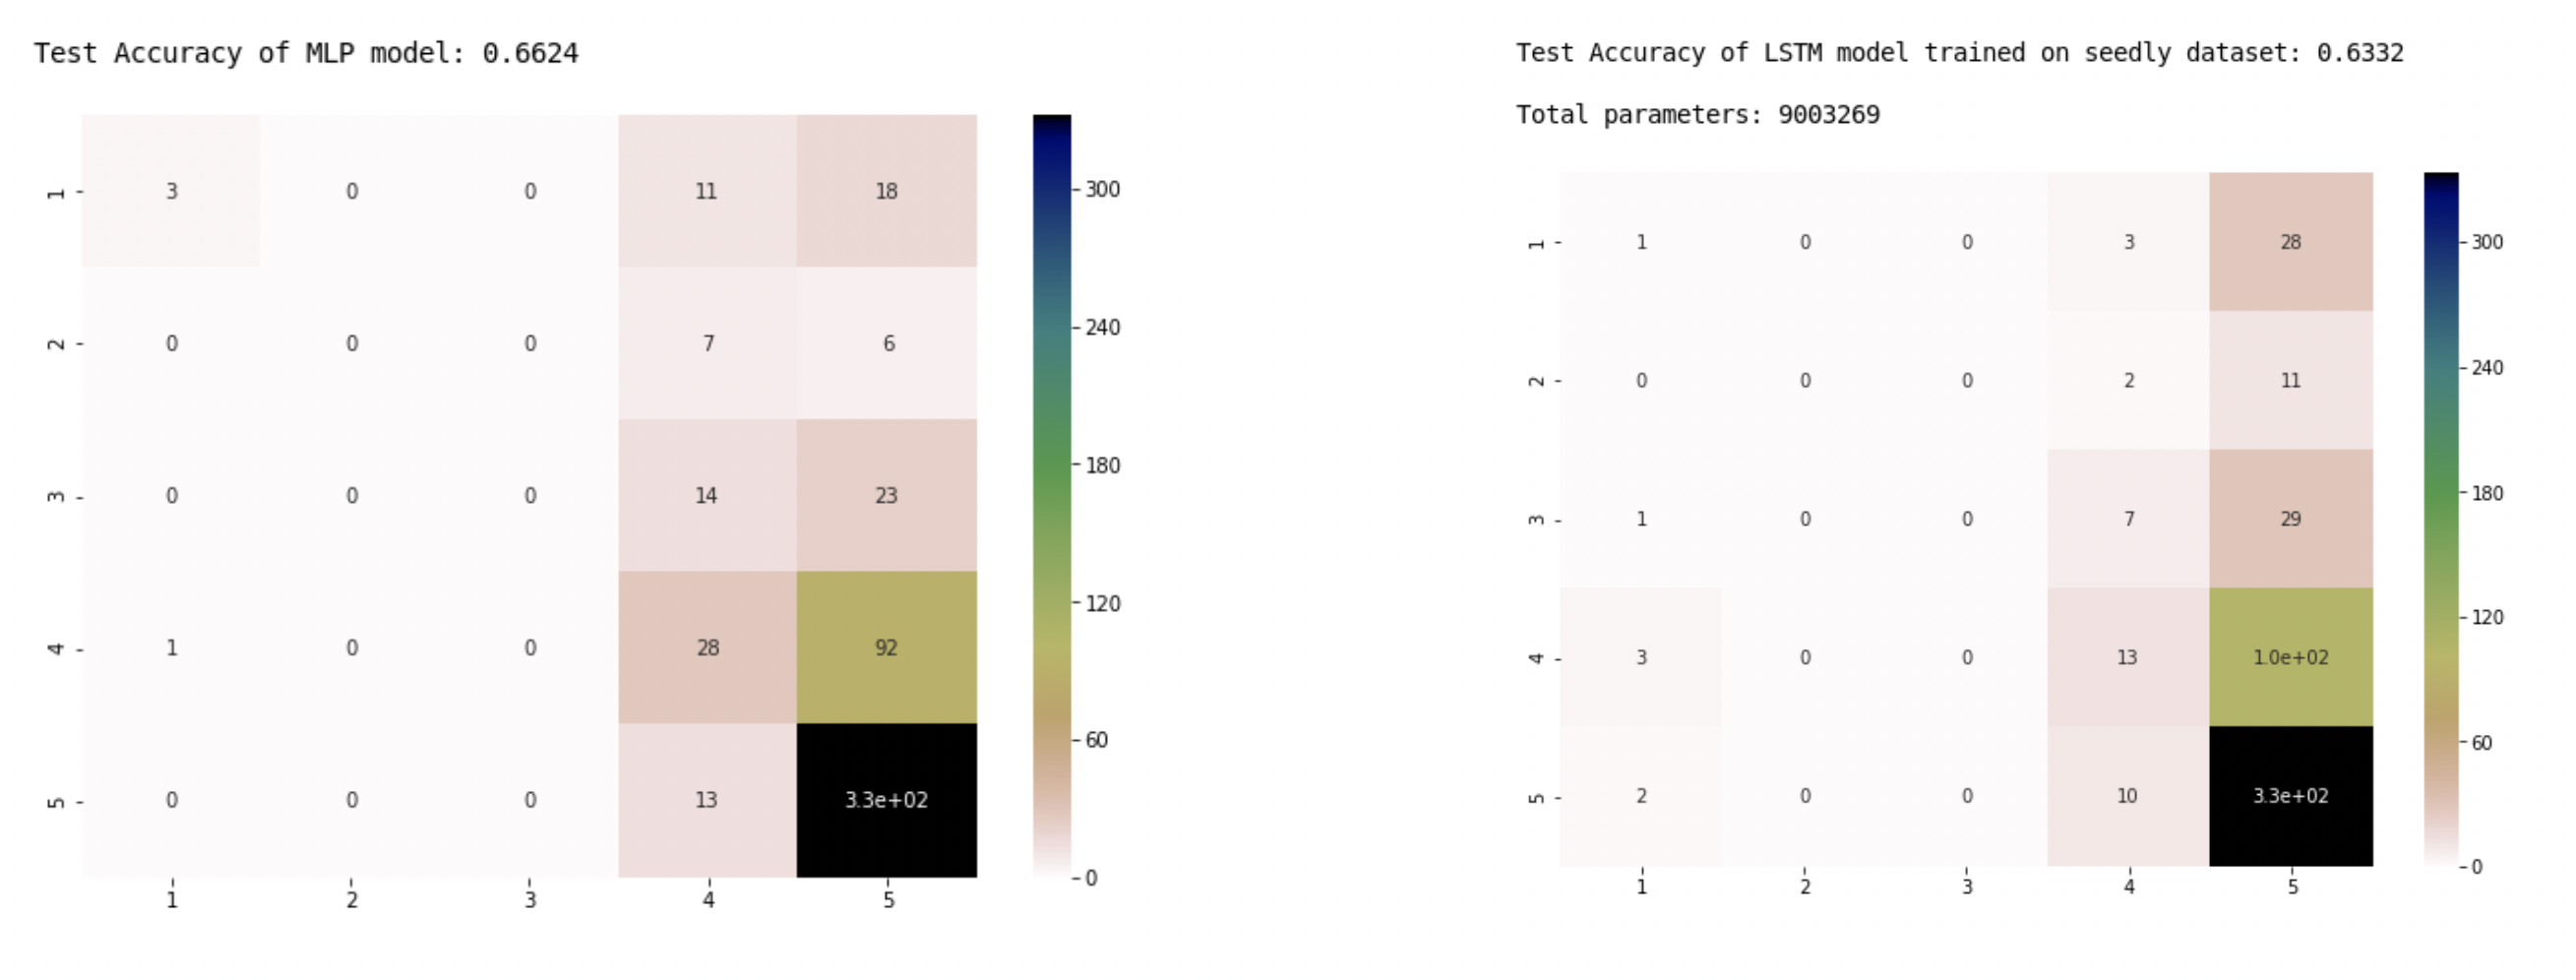

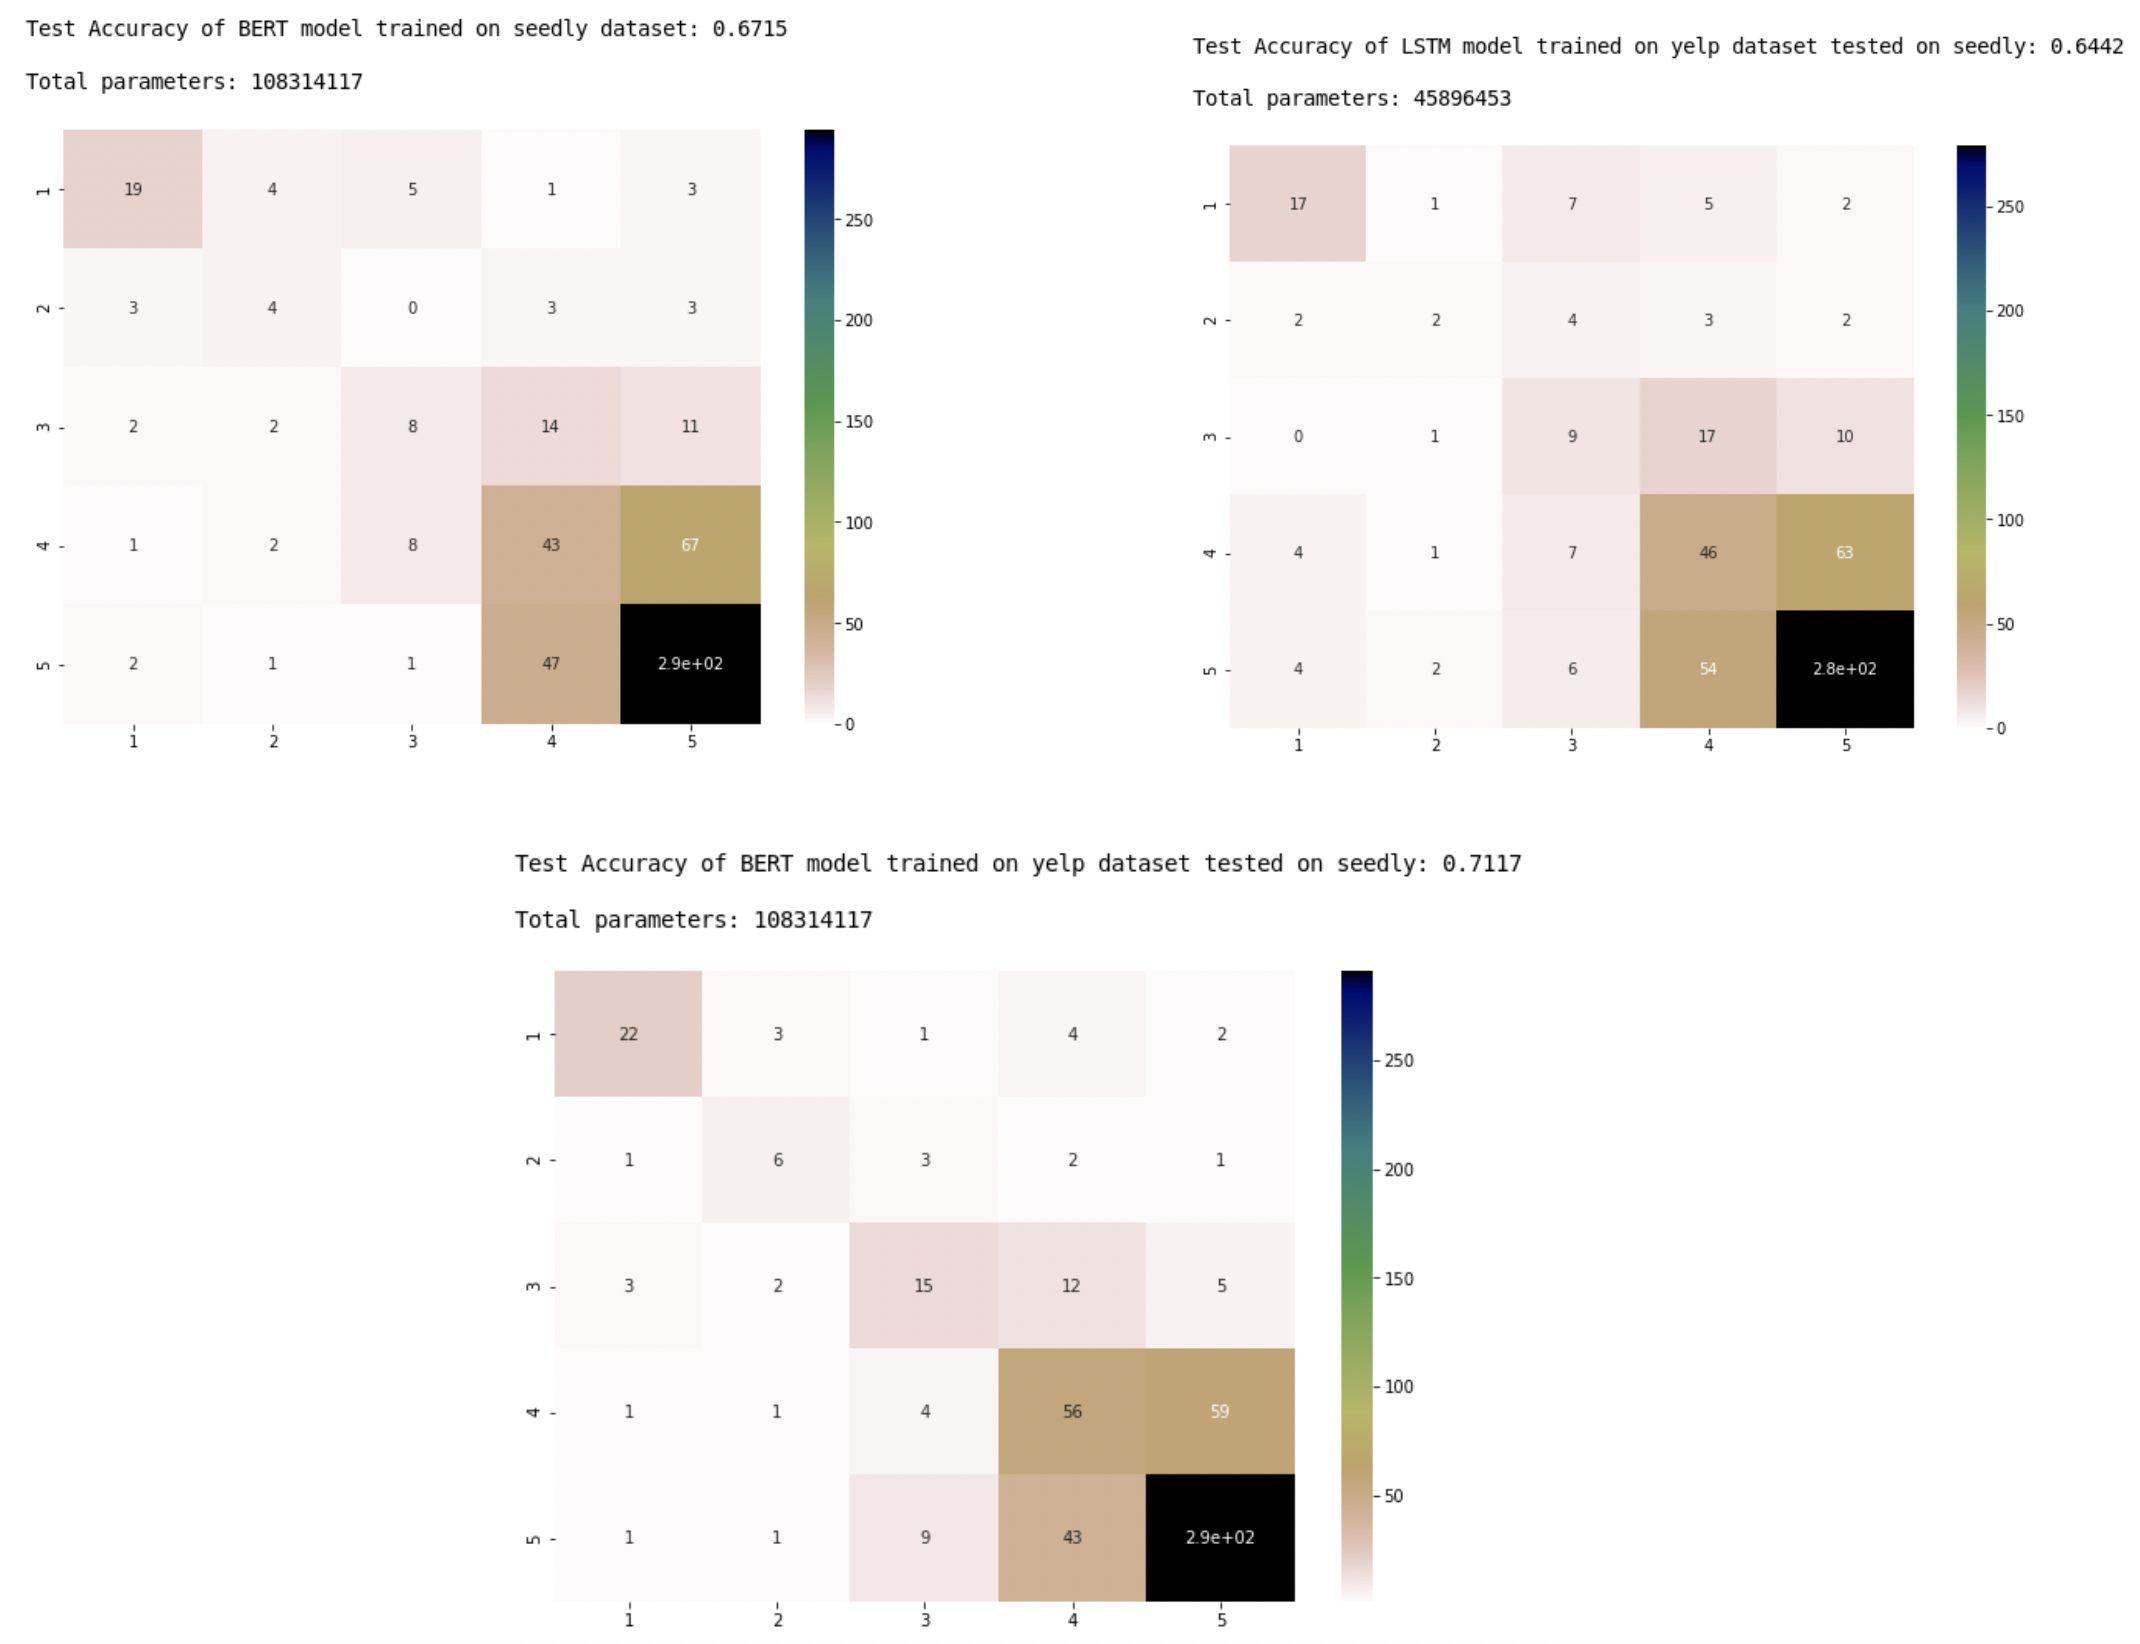

### 6. Conclusion 

In this project, the classification of ratings from the text reviews using deep learning has been studied on a new dataset. The dataset, scraped from [Seedly](http://seedly.sg), consists of the reviews of products and services in Singapore by the local users, giving us a new context to study. We develop multiple classifiers on this data and present their results. Since this data size is relatively small as compared to standard text datasets for reviews related tasks, we use Yelp dataset to aid model training and consequently improve the classification accuracy on the seedly dataset. We also show the importance of transformers based deep learning models (BERT, in this project) in achieving a higher performance against the traditional LSTM.